In [1]:
# ----------------------------------------------------------------------
# Importamos las librerías principales
# ----------------------------------------------------------------------

import os
import numpy as np
from numpy import linalg as LA
import warnings

# Para graficar
import matplotlib.pyplot as plt
from seaborn import color_palette

# Para animar y visualizar animaciones
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

# QP solvers
#!pip install qpsolvers
#from qpsolvers import solve_qp

# ----------------------------------------------------------------------
# CBF_tools
# ----------------------------------------------------------------------

# Toolbox
from CBF_tools.toolbox import unicycle_patch, fmt_data_axis, cone_params, createDir

# GVF trajectories
from CBF_tools.gvf_traj_ellipse  import gvf_ellipse, draw

# GVF + CBF simulator
from CBF_tools.simulator import simulator

# ----------------------------------------------------------------------
# Variables globales
# ----------------------------------------------------------------------
FOLDER_OUTPUT = "output"

# Paletas de colores suaves (https://g.co/kgs/4A3q4T)
cake_b = "#d9daff"
cake_r = "#ffdbd9"
cake_y = "#fffbd9"
cake_g = "#dcffd9"

# ----------------------------------------------------------------------
# Init
# ----------------------------------------------------------------------
createDir(FOLDER_OUTPUT)

¡El directorio 'output' ya existe!


## Simulation 1:

In [17]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 4, 4
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 80**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 1/60
t0 = 0
t_sim_final = 40

# Constantes de los controladores
ke = 0.2
kn = 2

r = 2
gamma = 1
A = lambda p_norm: np.array([[1,0],[0,r/p_norm]])
A_dot = lambda p_norm: np.array([[0,0],[0,-r/p_norm]])

# Estado inicial de los agentes y número de agentes
n_agents = 10

# Alineados
pij_init = 2*r
p0 = np.zeros((n_agents, 2))
p0[:,0] = - np.linspace(1.1*a, 1.1*a + pij_init*(n_agents-1), n_agents)

# Ordenados por velocidad
vi_slower = 0.2
vij = np.random.rand(n_agents-1)/2 + 0.2 # aleatoria
#vij = 0.2*np.ones(n_agents-1) # paso fijo

v0 = np.ones((n_agents,1)) * vi_slower 
for n in range(n_agents-1):
    v0[n+1] = v0[n] + vij[n]

v0 = v0

# Alineados en dirección
phi0 = np.ones(n_agents) * (np.pi/2)

# Generamos los vectores de estado iniciales
x0 = [t0, p0, v0, phi0]

In [19]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, t_cbf=0, A=A, A_dot=A_dot)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []

preldata = []
omega = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    preldata.append(sim.p_rel)
    omega.append(sim.w)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

preldata = np.linalg.norm(np.array(preldata), axis=3)
omega = np.array(omega)

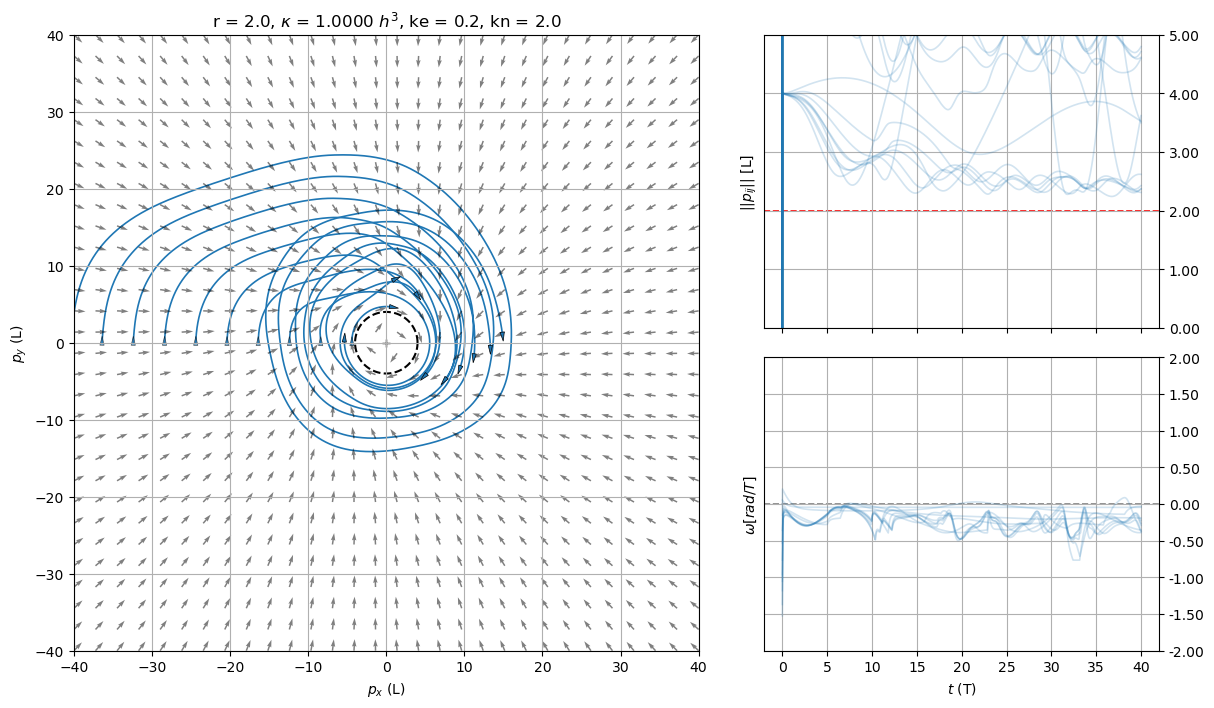

In [20]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(14, 8)
dpi=100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-40,40])
main_ax.set_ylim([-40,40])
main_ax.set_ylabel(r"$p_y$ (L)")  
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title(r"r = {0:.1f}, $\kappa$ = {1:.4f} $h^3$, ke = {2:.1f}, kn = {3:.1f}".format(r, gamma, ke, kn))

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[0]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

# Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(r, c="red", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      prel_ax.plot(time_vec, preldata[:,n,k], c=color_palette()[0], lw=1.2, alpha=0.2)

plt.show()

In [21]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

n_tail = 50
figsize=(14, 8)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax      = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-30,30])
main_ax.set_ylim([-30,30])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
c_palet = color_palette()
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[0])
#  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
#  icon_init.set_alpha(0.6)
#  icon_init.set_label("n"+str(n))


#  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[0],
                       ls="-", lw=0.8)

  lines_plt.append(line)
  icons_plt.append(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)
txt_title = main_ax.set_title(r"r = {0:.1f}, $\kappa$ = {1:.4f} $h^3$, ke = {2:.1f}, kn = {3:.1f}".format(r, gamma, ke, kn))

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(r, c="red", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      prel_ax.plot(time_vec, preldata[:,n,k], c=color_palette()[0], lw=1.2, alpha=0.2)

pline = prel_ax.axvline(0, c="black", ls="--", lw=1.2)
wline = wdata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[0])
    icons_plt[n].set_zorder(3)

    main_ax.add_patch(icons_plt[n])

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  pline.set_xdata(i*dt)
  wline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=1/25)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tf =  0.00 | 0.00%
tf =  0.00 | 0.00%


tf =  3.98 | 9.97%
tf =  7.97 | 19.93%
tf = 11.95 | 29.90%
tf = 15.93 | 39.87%
tf = 19.92 | 49.83%
tf = 23.90 | 59.80%
tf = 27.88 | 69.77%
tf = 31.87 | 79.73%
tf = 35.85 | 89.70%
tf = 39.83 | 99.67%
